# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile

from PIL import Image
from PIL import ImageDraw
import pytesseract
import cv2
import numpy as np

# loading the face detection classifier
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

In [2]:
# creat dictionary with all images in the archive
def zip_to_pil(filename, verbose=False):
    if verbose:
        print('Extract images from ' + filename)
    images_dct = {}
    with zipfile.ZipFile(filename) as zimgs:
        for entry in zimgs.infolist():
            with zimgs.open(entry) as file:
                pil_img = Image.open(file)
                images_dct[file.name] = {'pil_img': pil_img}
                if verbose:
                    print(pil_img.size, pil_img.mode, len(pil_img.getdata()))
    if verbose:
        print('Done.')
    return images_dct

In [3]:
# extract text from all of the images
def extract_text(dct, verbose=False):
    if verbose:
        print('Extract text.')
    for img_iter in dct:
        if verbose:
            print(img_iter)
        img_iter_grey = dct[img_iter]['pil_img'].convert('L')
        dct[img_iter]['text'] = pytesseract.image_to_string(img_iter_grey)
    if verbose:
        print('Done.')
    return dct

In [4]:
# extract faces from all of the images
def detect_faces(dct, verbose=False):
    if verbose:
        print('Detecting faces.')
    for img_iter in dct:
        if verbose:
            print(img_iter)
        img_iter_cv2 = np.array(dct[img_iter]['pil_img'])
        img_iter_cv2 = cv2.cvtColor(img_iter_cv2, cv2.COLOR_RGB2GRAY)
        dct[img_iter]['faces'] = face_cascade.detectMultiScale(img_iter_cv2, scaleFactor=1.3,
                                                               minNeighbors=3, minSize=(50, 50))
    if verbose:
        print('Done.')
    return dct

In [5]:
# draw boxes around faces
def draw_detection_boxes(dct):
    for img in dct:
        print(img)
        img_iter = dct[img]['pil_img'].copy()
        drawing = ImageDraw.Draw(img_iter)
        for rec in images_dct[img]['faces']:
            rec_drw = rec.tolist()
            drawing.rectangle((rec_drw[0], rec_drw[1], rec_drw[0] + rec_drw[2], rec_drw[1] + rec_drw[3]), 
                              outline="blue")
        display(img_iter)

In [6]:
# keyword checker
def check_keyword(img_dct, keyword):
    return keyword in img_dct['text']

In [7]:
# face panel generator
def gen_contact_sheet(img_dct, faces_in_row=5, face_box_width=100, face_box_height=100):
    
    num_faces = len(img_dct['faces'])
    if num_faces == 0:
        return None
    else:
        if num_faces % 5 != 0:
            num_rows = num_faces // 5 + 1
        else:
            num_rows = num_faces // 5
        contact_sheet = Image.new('RGB', (faces_in_row * face_box_width, face_box_height * num_rows))
    
    return contact_sheet

In [8]:
def get_keyword_related_faces(dct, keyword, faces_in_row=5, face_box_width=100, face_box_height=100):
    for image in dct:
        if check_keyword(dct[image], keyword):
            print('Results found in file ' + image)
            contact_sheet = gen_contact_sheet(dct[image])
        else:
            continue
        if contact_sheet is None:
            print('But there were no faces in that file!')
        else:
            x_contact = 0
            y_contact = 0
            for face in dct[image]['faces']:
                cropped_img = dct[image]['pil_img'].copy()
                x, y, h, w = tuple(face)
                cropped_img = cropped_img.crop((x, y, x + h, y + w))
                if cropped_img.width > face_box_width or cropped_img.height > face_box_height:
                    cropped_img = cropped_img.resize((face_box_height, face_box_width))
                
                contact_sheet.paste(cropped_img, (x_contact, y_contact))
                if x_contact + face_box_width == contact_sheet.width:
                    x_contact = 0
                    y_contact = y_contact + face_box_height
                else:
                    x_contact = x_contact + face_box_width
            display(contact_sheet)

In [9]:
# zip files names
filename_small = 'data/course5_small_img.zip'
filename_large = 'data/course5_images.zip'

images_small = zip_to_pil(filename_small, verbose=True)
images_large = zip_to_pil(filename_large, verbose=True)


images_small = extract_text(images_small, verbose=True)
images_large = extract_text(images_large, verbose=True)

images_small = detect_faces(images_small, verbose=True)
images_large = detect_faces(images_large, verbose=True)

# draw_detection_boxes(images_small)
# draw_detection_boxes(images_large)

Extract images from data/course5_small_img.zip
(3600, 6300) RGB 22680000
(3600, 6300) RGB 22680000
(3600, 6300) RGB 22680000
(7200, 6300) RGB 45360000
Done.
Extract images from data/course5_images.zip
(3600, 6300) RGB 22680000
(3600, 6300) RGB 22680000
(6300, 3600) RGB 22680000
(3150, 3600) RGB 11340000
(3150, 3600) RGB 11340000
(3150, 3600) RGB 11340000
(3600, 6300) RGB 22680000
(7200, 6300) RGB 45360000
(3600, 6300) RGB 22680000
(3600, 6300) RGB 22680000
(3600, 6300) RGB 22680000
(3150, 3600) RGB 11340000
(3150, 3600) RGB 11340000
(3150, 3600) RGB 11340000
Done.
Extract text.
a-0.png
a-1.png
a-2.png
a-3.png
Done.
Extract text.
a-0.png
a-1.png
a-10.png
a-11.png
a-12.png
a-13.png
a-2.png
a-3.png
a-4.png
a-5.png
a-6.png
a-7.png
a-8.png
a-9.png
Done.
Detecting faces.
a-0.png
a-1.png
a-2.png
a-3.png
Done.
Detecting faces.
a-0.png
a-1.png
a-10.png
a-11.png
a-12.png
a-13.png
a-2.png
a-3.png
a-4.png
a-5.png
a-6.png
a-7.png
a-8.png
a-9.png
Done.


Results found in file a-0.png


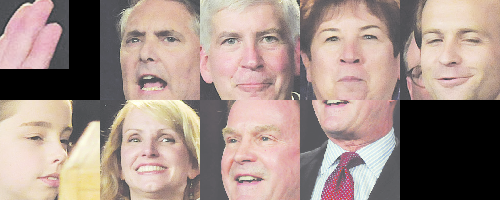

Results found in file a-3.png


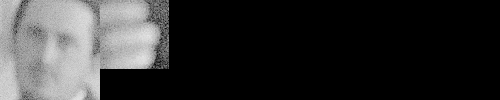

In [10]:
get_keyword_related_faces(images_small, 'Christopher')

Results found in file a-0.png


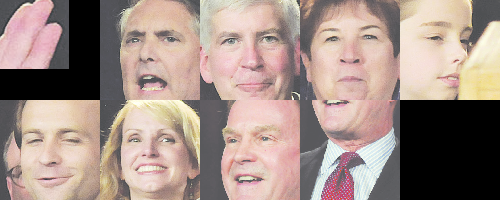

Results found in file a-1.png


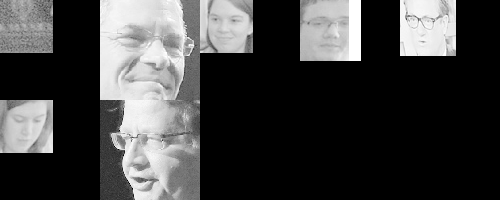

Results found in file a-10.png


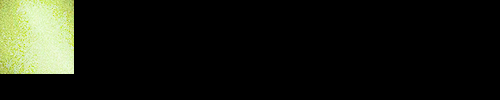

Results found in file a-13.png


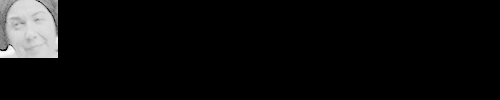

Results found in file a-2.png


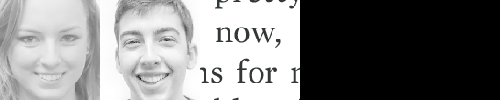

Results found in file a-3.png


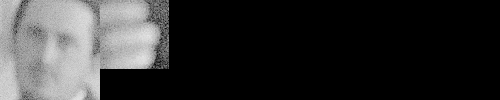

Results found in file a-8.png
But there were no faces in that file!


In [11]:
get_keyword_related_faces(images_large, 'Mark')